# Import Required Modules

In [451]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from IPython.display import HTML
%matplotlib inline

In [452]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

# Import Dataset
The dataset was downloaded from the [Brainspan - Atlas of the Developing Human Brain](http://www.brainspan.org/static/download.html) website on April 6, 2018.

In [262]:
# change working directory to directory with data files
os.chdir("/Users/daniel/Documents/Yale/Projects/computations/Allen_brain_development/genes_matrix_csv/")

# load data file and two files with metadata
gene_metadata = pd.read_csv("rows_metadata.csv")
patients_metadata = pd.read_csv("columns_metadata.csv")
expression_data = pd.read_csv("expression_matrix.csv", header=None, index_col=0)

# Data Overview
The database provides RNA-sequencing results (in RPKM units) for 524 samples:

data file | size (rows, cols)
--------- | -----------------
`gene_metadata` | 52376, 5
`patients_metadata` | 524, 8
`expression_data` | 52376, 524

# Cleaning and Joining Data Files
The joined data file `expression_data_joined` is of size 524, 52376+4 (patients, genes + `age`, `gender`, `structure_acronym`, `structure_name`) with indices being `donor_name`s and column names being gene names.

In [264]:
def transform_data():
    '''
    Run this function once to transform/join above input data files --> creates and returns 
    "expression_data_joined". Assign function to keep return value alive!
    '''
    # join gene_metadata with expression data
    _gene_metadata = gene_metadata.set_index("row_num", drop=True)
    _gene_metadata = _gene_metadata.drop(["gene_id", "ensembl_gene_id", "entrez_id"], axis=1)
    _expression_data_joined = _gene_metadata.join(other=expression_data)
    _expression_data_joined = _expression_data_joined.set_index("gene_symbol", drop=True).transpose()
    
    # join patients_metadata with expression data (/joined data frame from above)
    _patients_metadata = patients_metadata.set_index("column_num", drop=True).drop(
        ["donor_id", "donor_name", "structure_id"], axis=1)
    _expression_data_joined = _patients_metadata.join(other=_expression_data_joined)
    
    # return the joined table as described above
    return(_expression_data_joined)

expression_data_joined = transform_data()

In [442]:
# replace age column with float
def replace_age(_input=expression_data_joined):
    '''
    Replace string values of 'age' column with floats (depending on unit).
    '''
    # define regex patterns for replacement
    pattern1 = re.compile("^.*pcw$")
    pattern2 = re.compile("^.*mos$")
    pattern3 = re.compile("^.*yrs$")
    
    # create a new age column: age_in_years
    _input["age_in_years"] = None
    
    # loop over 'age' column and replace with appropriate value
    for i in range(len(_input.age.values)):
        # test for pattern 1
        if bool(pattern1.match(_input.age.values[i])):
            _res = round((- (40 - int((_input.age.values[i].split()[0]))) / 52), 2)
            _input.loc[_input.index[i], "age_in_years"] = _res
        # test for pattern 2
        elif bool(pattern2.match(_input.age.values[i])):
            _res = round(((int(_input.age.values[i].split()[0])) / 12), 2)
            _input.loc[_input.index[i], "age_in_years"] = _res
        # test for pattern 3
        if bool(pattern3.match(_input.age.values[i])):
            _res = int(_input.age.values[i].split()[0])
        _input.loc[_input.index[i], "age_in_years"] = _res            
    
    # convert 'age_in_years' column to float type
    _input["age_in_years"] = _input["age_in_years"].astype(float)
    
    # return the data frame with transformed 'age' column
    return(_input)

expression_data_joined = replace_age()

# add a dichotomized age column
expression_data_joined["Age Category"] = np.array(
    ["< 10 yrs" if value < 10 else ">= 10 yrs" for value in expression_data_joined["age_in_years"]])

# create a version of data frame with log2 transformed NCS1 expression
expression_data_joined_log2 = expression_data_joined.copy()
expression_data_joined_log2[["NCS1"]] = np.log2(expression_data_joined[["NCS1"]]+1)

# Exploratory Data Analysis
Scatter plots of NCS1 expression levels (gene level RPKM values) vs. donor age, stratified according to brain regions.

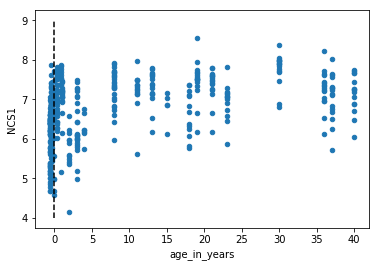

In [443]:
expression_data_joined_log2.plot(x="age_in_years", y="NCS1", kind="scatter");
plt.vlines(x=0, ymin=4, ymax=9, colors="black", linestyles="dashed");

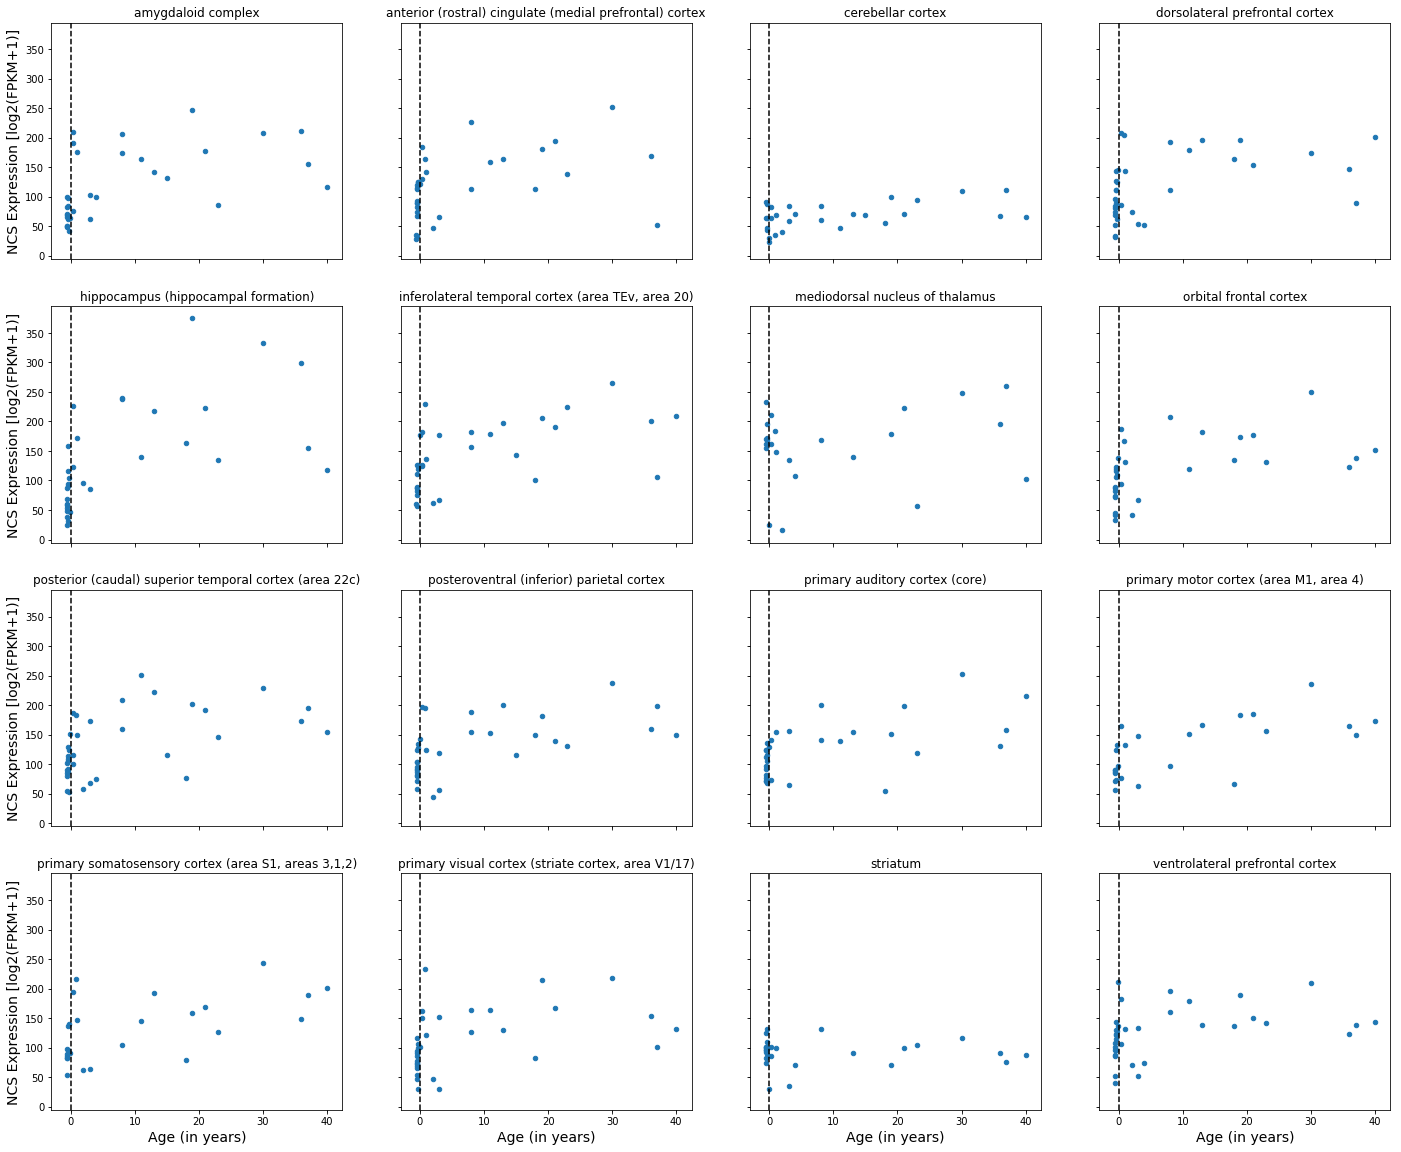

In [406]:
# plot unique brain regions:
regions, counts = np.unique(expression_data_joined.structure_name, return_counts=True)
regions = regions[counts > 10]

def plot_unique_regions(df, regions=regions):
    '''
    Docstring
    '''
    # create subplots according to length of regions array [19]; this could be automatized...
    fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), 
          (ax9, ax10, ax11, ax12), (ax13, ax14, ax15, ax16)) = plt.subplots(nrows=4, ncols=4, sharey=True, 
                                                                            sharex=True, figsize=(24, 20))
    
    # generate an iterator
    axes = iter(list([ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15, ax16]))
        
    # loop over selected regions
    for region in regions:
        _df = df[df["structure_name"] == region]
        _axis = next(axes)
        _df.plot(x="age_in_years", y="NCS1", kind="scatter", ax=_axis);
        _axis.set_title(str(region));
        _axis.axvline(x=0, color="black", linestyle="dashed")
        _axis.set_xlabel("Age (in years)", fontsize=14)
        _axis.set_ylabel("NCS Expression [log2(FPKM+1)]", fontsize=14)        
        
plot_unique_regions(df=expression_data_joined, regions=regions)

In [444]:
unique, counts = np.unique(expression_data_joined_log2["structure_name"], return_counts=True)
_dict1 = dict(zip(unique, counts))
_dict2 = dict(zip(pd.unique(expression_data_joined_log2["structure_name"]),
                  pd.unique(expression_data_joined_log2["structure_acronym"])))

dicts = [_dict1, _dict2]
regions_dict = {}

# loop over dictionaries and replace values by tuples ('acronym', int(count))
for d in dicts:
    for k, v in d.items():
        if k in regions_dict:
            regions_dict[k] = (regions_dict[k], v)
        else:
            regions_dict[k] = v

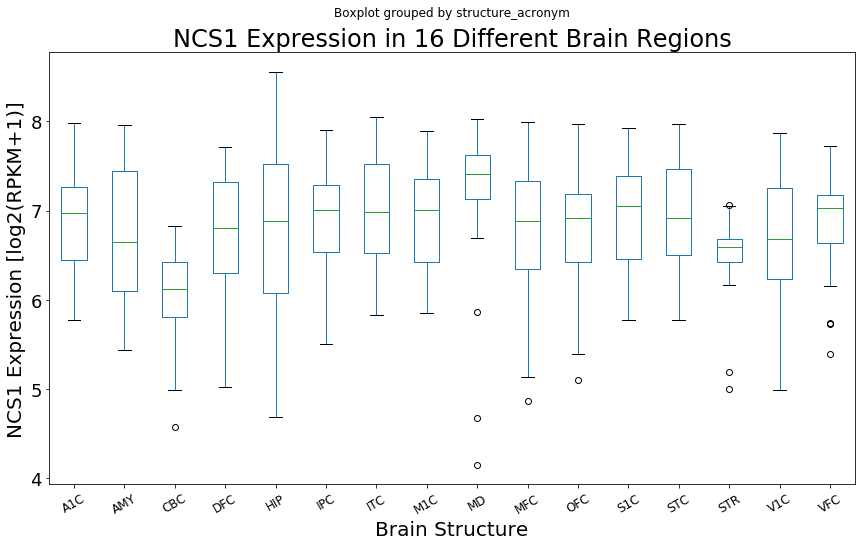

In [448]:
## boxplot of NCS1 expression levels for different brain regions
# identify brain regions with at least 10 observations... 
regions, counts = np.unique(expression_data_joined.structure_name, return_counts=True)
regions = regions[counts > 10]

# filter dataframe accordingly...
_df = expression_data_joined_log2[["NCS1", "structure_name", "structure_acronym", "Age Category"]]
_df = _df[_df["structure_name"].isin(regions)]

# ... and plot.
_df.boxplot("NCS1", "structure_acronym", figsize=(14, 8), rot=30, grid=False);
plt.title("NCS1 Expression in 16 Different Brain Regions", fontsize=24);
plt.xlabel("Brain Structure", fontsize=20);
plt.ylabel("NCS1 Expression [log2(RPKM+1)]", fontsize=20);
plt.xticks(fontsize=12);
plt.yticks(fontsize=18);

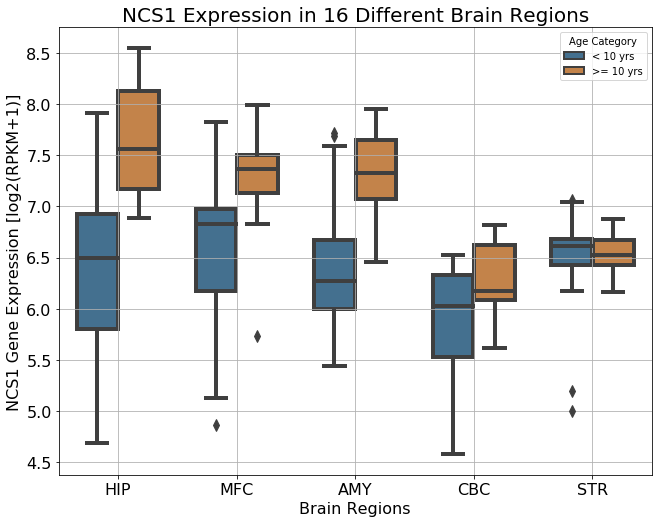

In [459]:
# select four brain regions of interest
_dis = ["AMY", "STR", "MFC", "CBC", "HIP"]
_df_selected = _df[([True if value in _dis else False for value in _df.structure_acronym.values])]

# plot either all or just selected brain regions
fc = sns.factorplot(x="structure_acronym", y="NCS1", hue="Age Category", saturation=0.5, width=0.7, fliersize=8, linewidth=4,
                    data=_df_selected, kind="box", size=7, aspect=1.3, legend_out=False, 
                    order=["HIP", "MFC", "AMY", "CBC", "STR"]); 
fc.despine(top=False, right=False);
plt.grid(b=True, which="major");
plt.ylabel("NCS1 Gene Expression [log2(RPKM+1)]", fontsize=16);
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Brain Regions", fontsize=16);

plt.title("NCS1 Expression in 16 Different Brain Regions", fontsize=20);
plt.savefig("/Users/daniel/Desktop/NCS1_in_16_brain_regions.pdf", bbox_inches="tight", pad_inches=1)